# Using just the last output of LSTM per sequence

Lets imagine you want to classify sequences. Sometimes it might not make sense to classify on each element of the sequence, so you need to use just the last output (or the last N outputs) of your LSTM.

Lets generate some sequences that we might care about. You can choose the example you want by selecting the proper index to `EXAMPLE` below.

In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, sym
from mxnet import gluon

EXAMPLE = ['simple', 'long-term-test', 'hard', 'lang'][3]
print('Running the', EXAMPLE, 'example')

if EXAMPLE == 'simple':
    X, y = list(zip(*[(label*np.ones((np.random.randint(low=5, high=100),)), label)
                      for label in np.random.choice(range(3), size=1000)]))
elif EXAMPLE == 'long-term-test':
    X, y = list(zip(*[(1.0*(np.arange(np.random.randint(low=5, high=100)) <= label), label)
                      for label in np.random.choice(range(3), size=1000)]))
elif EXAMPLE == 'hard':
    X, y = list(zip(*[(1.0*(np.random.random((np.random.randint(low=5, high=100),)) > 1.0/(label+2.0)), label)
                      for label in np.random.choice(range(3), size=1000)]))
elif EXAMPLE == 'lang':
    import requests, re
    novels = [
        (0, 'http://www.gutenberg.org/cache/epub/2000/pg2000.txt'), # Spanish
        (1, 'https://www.gutenberg.org/files/46787/46787-0.txt'), # English
    ]
    
    def sentences(novel, min_len=30, max_len=300):
        for s in re.sub(r'\s+', ' ', requests.get(novel).text).split('.')[20:-20]:
            if len(s) > min_len and len(s) < max_len:
                yield s
    
    # Run through all the novels and grab all the sentences in the books and grab all the sentences
    X, y = list(zip(*[(np.array([ord(c) for c in s])/255.0, lang)
                      for lang, novel in novels
                      for s in sentences(novel)]))
print('We have', len(X), 'samples')

Running the lang example
We have 7566 samples


Lets plot a couple of these sequences to understand what they look like,

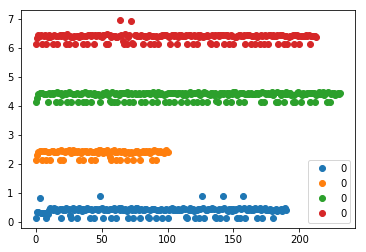

In [2]:
import matplotlib.pyplot as plt

for i, x in enumerate(X[:4]):
    plt.plot(x + 2*i, 'o')

plt.legend(y[:4])
plt.show()

The basic idea is that some sequences have more "ups" than "downs" and each sequence is a different length. We'd like to be able to classify each sequence into the percent of ups to downs.

Lets define a new kind of network.

In [3]:
class LastNet(gluon.Block):
    def __init__(self, recurrent_width, forward_width, **kwargs):
        super(LastNet, self).__init__(**kwargs)
        with self.name_scope():
            self._rnn = gluon.rnn.LSTM(recurrent_width)
            self._nn  = gluon.nn.Dense(forward_width)

    def forward(self, x):
        h = self._rnn(x)
        return self._nn(h[h.shape[0]-1])

It is important to check that the gradients will get computed properly. I was skeptical, so I wrote this quick test that constructs an arbitrary sequence, pushes it through an LSTM, and then computes the loss using only the last output.

In [4]:
for length in [1, 2]:
    x = nd.array([3]*length).reshape((-1, 1, 1))

    layer = gluon.rnn.LSTM(1)
    layer.initialize()
    with autograd.record():
        out = layer(x)
        loss = nd.mean((out[out.shape[0]-1] - 2)**2)
    loss.backward()

    print('Gradient using only last output for sequence length', length, 
          *['\n\t%s:%s' % (name, p.grad().asnumpy().flatten()) for name, p in layer.params.items()], '\n\n')

Gradient using only last output for sequence length 1 
	lstm0_l0_i2h_weight:[-0.03023597  0.         -3.27786589 -0.028655  ] 
	lstm0_l0_h2h_weight:[ 0.  0.  0.  0.] 
	lstm0_l0_i2h_bias:[-0.01007866 -0.         -1.09262192 -0.00955167] 
	lstm0_l0_h2h_bias:[-0.01007866 -0.         -1.09262192 -0.00955167] 


Gradient using only last output for sequence length 2 
	lstm1_l0_i2h_weight:[-0.31645533 -0.10482672 -3.71678162 -0.34464899] 
	lstm1_l0_h2h_weight:[-0.0025947  -0.00127264 -0.03042663 -0.00417328] 
	lstm1_l0_i2h_bias:[-0.10548511 -0.03494224 -1.23892713 -0.114883  ] 
	lstm1_l0_h2h_bias:[-0.10548511 -0.03494224 -1.23892713 -0.114883  ] 




Note that the hidden to hidden weights (ie. `h2h_weight`) only have a gradient when the sequence is length 2 or more. So I feel comfortable assuming that the gradients are computed properly.

Initialize the parameters,

In [5]:
if EXAMPLE == 'hard':
    BATCH_SIZE=20
    EPOCHS=100
elif EXAMPLE == 'lang':
    # This might have a hard time converging
    # in only 10 epochs, but when I ran with 50,
    # the loss plot showed that roughly 10 would have worked fine
    BATCH_SIZE=20
    EPOCHS=10
else:
    BATCH_SIZE=20
    EPOCHS=20

ctx = mx.cpu()

net = LastNet(100, 3)
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .1})

And train,

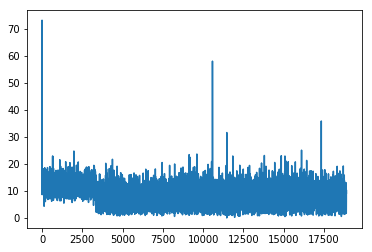

In [6]:
losses = []
for epoch in range(EPOCHS):
    for batch in np.random.choice(len(X), size=(int(len(X)/BATCH_SIZE), BATCH_SIZE)):
        with autograd.record():
            loss = sum(softmax_cross_entropy(net(nd.array(X[i]).reshape(shape=(-1, 1, 1))),
                                             nd.array([y[i]]).reshape((-1, 1)))
                       for i in batch)
        loss.backward()
        trainer.step(BATCH_SIZE)
        losses.append(loss.asscalar())
plt.plot(losses)
plt.show()

Quick demo that it actually learned something,

In [7]:
from sklearn.metrics import confusion_matrix

y_pred = [nd.softmax(net(nd.array(x).reshape((-1, 1, 1))), axis=1).asnumpy().flatten().argmax() for x in X]
confusion_matrix(y, y_pred)

array([[5480,    0],
       [ 971, 1115]])

For the language example, lets try testing on a set of sentences the RNN hasn't seen.

In [10]:
if EXAMPLE == 'lang':
    import requests, re
    novels = [
        (0, 'http://www.gutenberg.org/cache/epub/10822/pg10822.txt'), # Spanish
        (1, 'https://www.gutenberg.org/files/1342/1342-0.txt'), # English
    ]
    
    def sentences(novel, min_len=30, max_len=300):
        for s in re.sub(r'\s+', ' ', requests.get(novel).text).split('.')[20:520]:
            if len(s) > min_len and len(s) < max_len:
                yield s
    
    # Run through all the novels and grab all the sentences in the books and grab all the sentences
    X, y = list(zip(*[(np.array([ord(c) for c in s])/255.0, lang)
                      for lang, novel in novels
                      for s in sentences(novel)]))
    y_pred = [nd.softmax(net(nd.array(x).reshape((-1, 1, 1))), axis=1).asnumpy().flatten().argmax() for x in X]
    print(confusion_matrix(y, y_pred))

[[417   0]
 [224 165]]


It appears to have converged pretty well, except that the strong training bias towards Spanish sentences is apparent.